In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from mlxtend.regressor import StackingCVRegressor

In [2]:
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")

In [3]:
trainData.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
trainData.drop(['Id'], axis=1, inplace=True)
testData.drop(['Id'], axis=1, inplace=True)

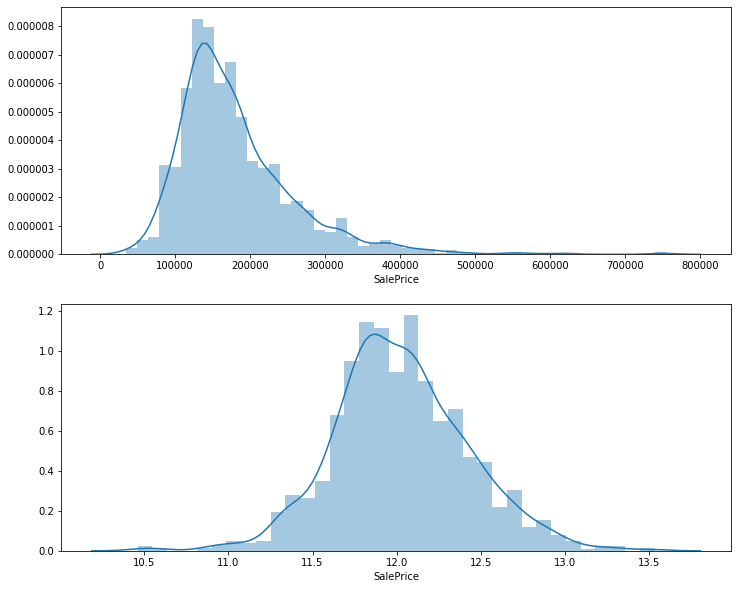

In [5]:
fig,axes = plt.subplots(ncols=1,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(trainData["SalePrice"],ax=axes[0])
sns.distplot(np.log(trainData["SalePrice"]),ax=axes[1])

In [6]:
trainData["SalePrice"] = np.log1p(trainData["SalePrice"])

## 处理离群点

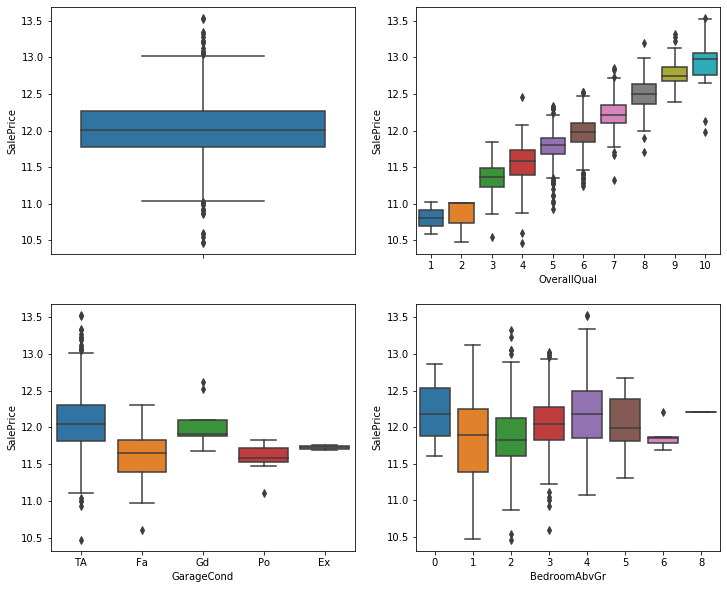

In [7]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=trainData,y="SalePrice",orient="v",ax=axes[0][0])
sns.boxplot(data=trainData,y="SalePrice",x="OverallQual",orient="v",ax=axes[0][1])
sns.boxplot(data=trainData,y="SalePrice",x="GarageCond",orient="v",ax=axes[1][0])
sns.boxplot(data=trainData,y="SalePrice",x="BedroomAbvGr",orient="v",ax=axes[1][1])

In [8]:
trainData = trainData[np.abs(trainData["SalePrice"]-trainData["SalePrice"].mean())<=(3*trainData["SalePrice"].std())]

trainData.reset_index(drop=True, inplace=True)

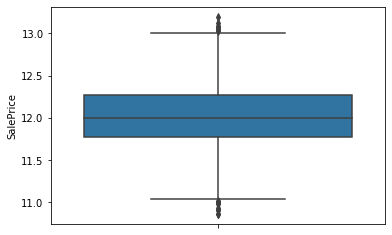

In [9]:
sns.boxplot(data=trainData,y="SalePrice",orient="v")

## 分析数据相关性

In [10]:
def extractValidFeatures(data, percent=0.4):
    thresh = int(data.shape[0]*percent)
    
    noNanCount = data.count()
    noNanCount = noNanCount[noNanCount>=thresh]
    return noNanCount.index

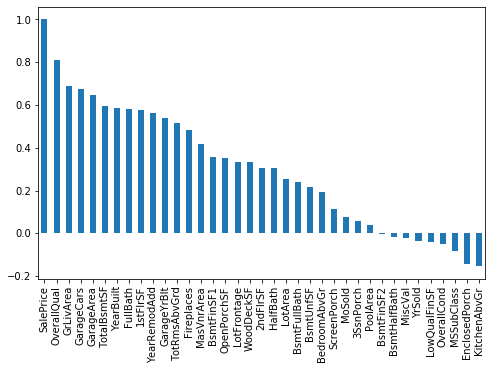

In [11]:
corr_matrix = trainData.corr()
corrmat = corr_matrix["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(8,5))
corrmat.plot.bar()

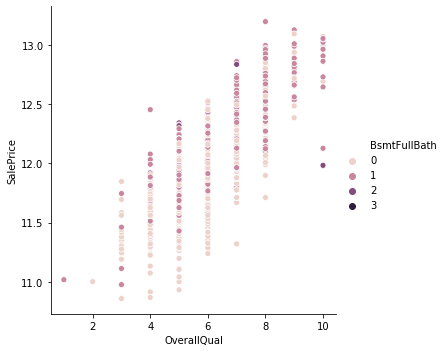

In [12]:
sns.relplot(x="OverallQual", y="SalePrice",
            hue = "BsmtFullBath",               #使用颜色来进行区分
            data = trainData)

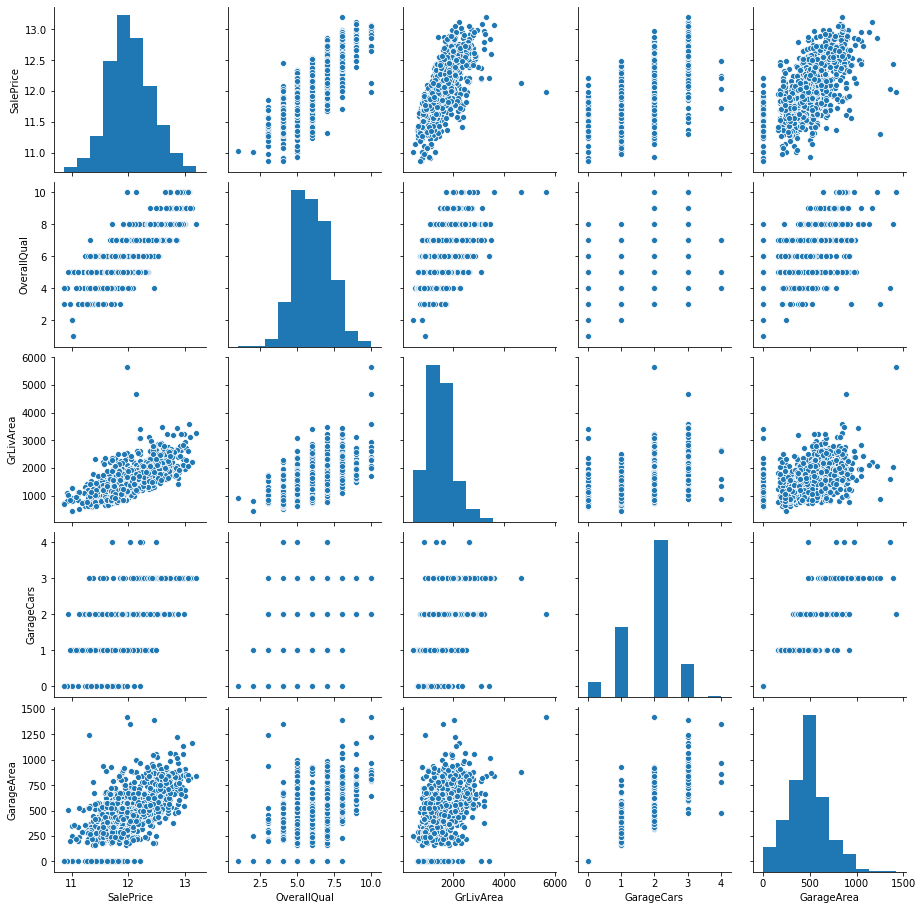

In [13]:
prepareIndex = corrmat[corrmat>0.6].index
sns.pairplot(trainData[prepareIndex])
plt.show()

In [14]:
train_labels = trainData['SalePrice'].reset_index(drop=True)
train_features = trainData.drop(['SalePrice'], axis=1)

valueFeature = extractValidFeatures(train_features)

train_features = trainData[valueFeature]

test_features = testData[valueFeature]

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2907, 75)

In [15]:
all_features.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


## 分离非数值型特征

In [16]:
def splitNumericFeatures(data):
    features = data.columns.tolist()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',]
    features_numeric = data.select_dtypes(include=numerics).columns.tolist()
    features_non_numeric = [f for f in features if f not in features_numeric]
    return (features, features_numeric, features_non_numeric)

In [17]:
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [18]:
features, features_numeric, features_non_numeric = splitNumericFeatures(all_features)

## 处理缺失值

In [19]:
def fillNan(data, num, nonum):
    for feature in nonum:
        item = data[feature]
        fillValue = item.value_counts().index[0]
        data[feature].fillna(fillValue, inplace=True)
        
    for feature in num:
        item = data[feature]
        fillValue = item.median()
        data[feature].fillna(fillValue, inplace=True)

In [20]:
fillNan(all_features, features_numeric, features_non_numeric)

## 修正特征的分布

In [21]:
skew_features = all_features[features_numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]

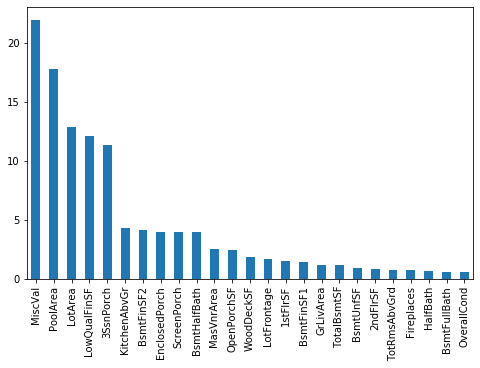

In [22]:
plt.figure(figsize=(8,5))
high_skew.plot.bar()

In [23]:
for i in high_skew.index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

C:\Ddisk\programer\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Ddisk\programer\lib\site-packages\scipy\stats\stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


C:\Ddisk\programer\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Ddisk\programer\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Ddisk\programer\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Ddisk\programer\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)
C:\Ddisk\programer\lib\site-packages\seaborn\categorical.py:483: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)


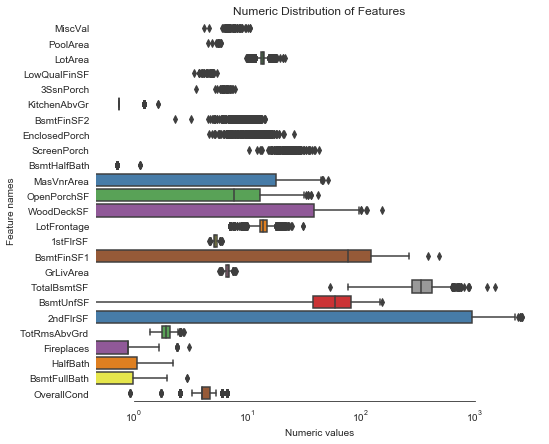

In [24]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[high_skew.index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

## 添加新特征

In [25]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street'], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## 融合log特征和二次方特征

In [26]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [27]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

In [28]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2907, 357)

In [29]:
all_features.head(10)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,13.522056,13.446949,7,3.993936,2003,2003,19.707594,119.922541,0.00000,30.041583,...,0,0,0,1,0,0,0,0,1,0
1,15.137388,13.717765,6,6.004665,1976,1976,54.598150,149.537822,0.00000,44.221565,...,0,0,0,1,0,0,0,0,1,0
2,13.859277,14.058405,7,3.993936,2001,2002,18.008771,93.069472,0.00000,57.017938,...,0,0,0,1,0,0,0,0,1,0
3,12.941839,13.706626,7,3.993936,1915,1970,54.598150,53.500533,0.00000,64.953289,...,0,0,0,1,1,0,0,0,0,0
4,15.541288,14.576019,8,3.993936,2000,2000,25.811810,113.977478,0.00000,61.300109,...,0,0,0,1,0,0,0,0,1,0
5,15.640713,14.553496,5,3.993936,1993,1995,54.598150,122.898747,0.00000,17.741842,...,0,0,0,1,0,0,0,0,1,0
6,14.617667,13.822927,8,3.993936,2004,2005,19.226817,187.708528,0.00000,47.241549,...,0,0,0,1,0,0,0,0,1,0
7,13.859277,13.885396,7,4.682626,1973,1973,21.671098,136.966926,4.74515,37.491526,...,0,0,0,1,0,0,0,0,1,0
8,11.831493,12.774864,7,3.993936,1931,1950,54.598150,665.141633,0.00000,90.928232,...,0,0,0,1,1,0,0,0,0,0
9,11.702151,13.173984,5,4.682626,1939,1950,54.598150,136.101927,0.00000,28.801798,...,0,0,0,1,0,0,0,0,1,0


## 分离训练集和测试集

In [30]:
all_features = all_features.loc[:,~all_features.columns.duplicated()]

X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1448, 356), (1448,), (1459, 356))

## 建立k折交叉验证

In [31]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

gbr = GradientBoostingRegressor(n_estimators=7000, learning_rate=0.1, max_depth=4, random_state=0, loss='ls')
dtree = tree.DecisionTreeRegressor()
ridge = linear_model.Ridge(alpha=.5)
svm = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))
randomForest = RandomForestRegressor(random_state=42)

stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, gbr, dtree, ridge, svm, randomForest),
                                meta_regressor=lightgbm,
                                use_features_in_secondary=True)

In [33]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1119 (0.0164)


In [34]:
X.dtypes

LotFrontage              float64
LotArea                  float64
OverallQual                int64
OverallCond              float64
YearBuilt                  int64
                          ...   
SaleCondition_AdjLand      uint8
SaleCondition_Alloca       uint8
SaleCondition_Family       uint8
SaleCondition_Normal       uint8
SaleCondition_Partial      uint8
Length: 356, dtype: object

In [35]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.1347 (0.0156)


In [36]:
score = cv_rmse(svm)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1175 (0.0343)


In [37]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1258 (0.0260)


In [38]:
score = cv_rmse(dtree)
print("dtree: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['dtree'] = (score.mean(), score.std())

dtree: 0.2022 (0.0213)


In [39]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1171 (0.0150)


In [40]:
score = cv_rmse(randomForest)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1320 (0.0156)


In [41]:
stack_gen.fit(np.array(X), np.array(train_labels))

StackingCVRegressor(cv=5,
                    meta_regressor=LGBMRegressor(bagging_fraction=0.8,
                                                 bagging_freq=4, bagging_seed=8,
                                                 boosting_type='gbdt',
                                                 class_weight=None,
                                                 colsample_bytree=1.0,
                                                 feature_fraction=0.2,
                                                 feature_fraction_seed=8,
                                                 importance_type='split',
                                                 learning_rate=0.01,
                                                 max_bin=200, max_depth=-1,
                                                 min_child_samples=20,
                                                 min_child_weight=0.001,
                                                 min_split_gain=0.0,
                                   

In [42]:
blended_predictions = stack_gen.predict(np.array(X))

blended_score = rmsle(train_labels, blended_predictions)
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.044876084537111983


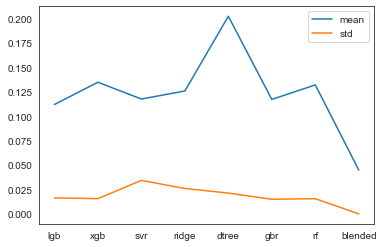

,lgb,xgb,svr,ridge,dtree,gbr,rf,blended
0,0.111915,0.134733,0.117524,0.125766,0.202228,0.117107,0.131969,0.044876
1,0.016419,0.015600,0.034317,0.026018,0.021327,0.014951,0.015614,0.000000


In [59]:
data = pd.DataFrame(scores)
plt.plot(data.columns, data.iloc[0,:], label="mean")
plt.plot(data.columns, data.iloc[1,:], label="std")
plt.legend()
plt.show()
data

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")

In [ ]:
sample_submission.iloc[:,1] = np.expm1(stack_gen.predict(np.array(X_test)))

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.to_csv("submission_regression2.csv", index=False)